<a href="https://colab.research.google.com/github/lucaskbobadilla/Bioinformatics-scripts/blob/main/Lucas_KB_module3_gnn_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework for Module 3 of Graph Neural Network**

In this assignment, we will construct graph convolutional network (GCN) by using PyTorch Geometric (PyG) and train and test the model using two Open Graph Benchmkar (OGB, https://ogb.stanford.edu/) datasets. OGB is a collection of realistic, large-scale, and diverse benchmark datasets for machine learning on graphs. These two datasets are used to benchmark the model on different tasks: node property prediction and graph property prediction.

First, we will look at one dataset from OGB.
Subsequently, we will build GCN by using PyG, and then apply and evaluate the models on node property prediction and grpah property prediction tasks. Please read each text block and all comments in all the code blocks in detail when you do the homework assignment.

**Note: Make sure to sequentially run all the cells in each section, so that the intermediate variables / packages will carry over to the next cell.**

# 1. Install Required Packages

Besides the relevant packages, we also need to install the OBG dataset.

In [3]:
# Install required packages.

!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-geometric

!pip install ogb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 3.7 MB/s eta 0:00:00


In [4]:
# Resolve the package version compatibility issue.
import functools
import torch
old_load = torch.load
torch.load = functools.partial(old_load, weights_only=False)

# 2. Open Graph Bemchmark (OGB)

The Open Graph Benchmark (OGB) is a collection of realistic, large-scale, and diverse benchmark datasets for machine learning on graphs. Its datasets are automatically downloaded, processed, and split using the OGB Data Loader. The model performance can also be evaluated by using the OGB Evaluator in a unified manner.

# Dataset and Data

OGB also supports the PyG dataset and data. Here we take a look on the `ogbn-arxiv` dataset.


In [5]:
import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset

dataset_name = 'ogbn-arxiv'
# Load the dataset and transform it to sparse tensor.
dataset = PygNodePropPredDataset(name=dataset_name,
                                 transform=T.ToSparseTensor())
print('The {} dataset has {} graph'.format(dataset_name, len(dataset)))

# Extract the graph.
data = dataset[0]
print(data)

Downloaded 0.08 GB: 100%|██████████| 81/81 [00:01<00:00, 59.75it/s]


Extracting dataset/arxiv.zip


Processing...


Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:00<00:00, 10407.70it/s]


Converting graphs into PyG objects...


100%|██████████| 1/1 [00:00<00:00, 3830.41it/s]

Saving...
The ogbn-arxiv dataset has 1 graph



Done!


Data(num_nodes=169343, x=[169343, 128], node_year=[169343, 1], y=[169343, 1], adj_t=[169343, 169343, nnz=1166243])


**Question 1:** What is the number of features in the `ogbn-arxiv` graph? (2 points)

Please use the following code block to answer the question.

In [6]:
def graph_num_features(data):
  # TODO: Implement this function that takes a PyG data object,
  # and returns the number of features in the graph (in integer).

  num_features = 0

  ############# Your code here ############
  ## (~1 line of code)
  # get the number of features
  num_features = data.num_features
  #########################################

  return num_features

num_features = graph_num_features(data)
print('The graph has {} features'.format(num_features))

The graph has 128 features


# 3. GNN: Node Property Prediction

In this section we will build our first graph neural network by using PyG and apply it on node property prediction (node classification).

We will build the graph neural network by using GCN operator (https://arxiv.org/abs/1609.02907).

You can use the PyG built-in `GCNConv` layer directly.

In [7]:
import torch
import torch.nn.functional as F
print(torch.__version__)

# The PyG built-in GCNConv
from torch_geometric.nn import GCNConv

import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator

2.8.0+cu126


# Load and Preprocess Dataset

In [8]:
# Make the adjacency matrix to symmetric
data.adj_t = data.adj_t.to_symmetric()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# If you use GPU, the device should be cuda
print('Device: {}'.format(device))

data = data.to(device)

# Split the index in the dataset.
split_idx = dataset.get_idx_split()
train_idx = split_idx['train'].to(device)

Device: cuda


# Construct GCN Model

Please follow the figure below to implement the `forward` function. (10 points)

Please see the code block for the comments on more instructions step by step.

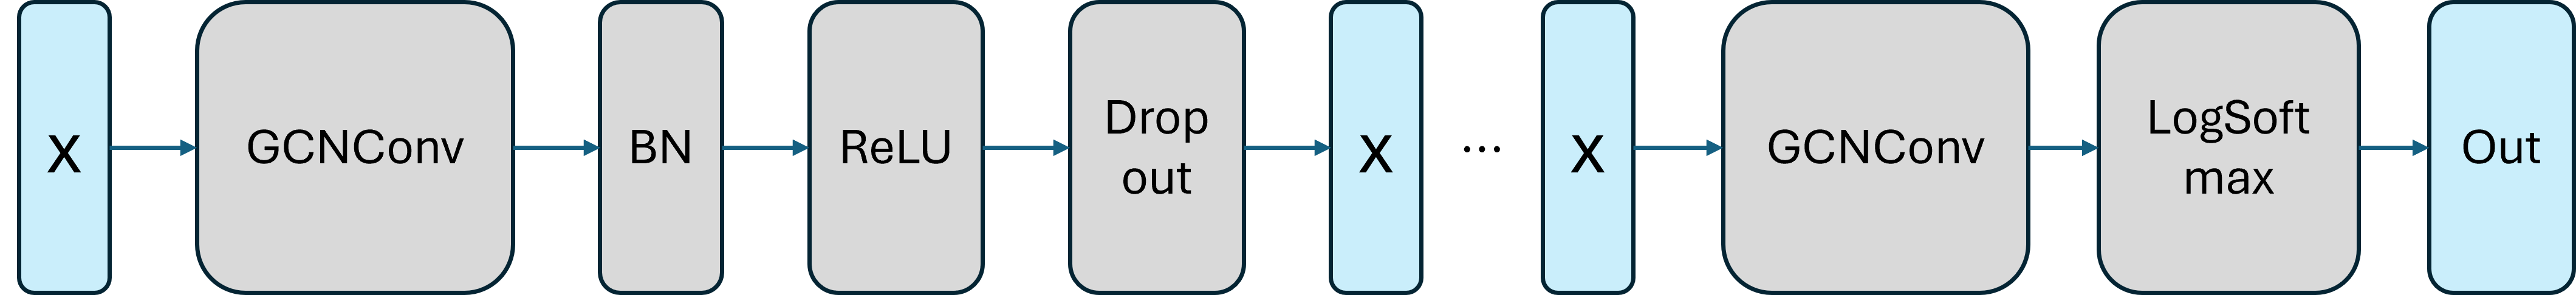

In [11]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,
                 dropout, return_embeds=False):
        # TODO: Implement this function that initializes self.convs,
        # self.bns, and self.softmax.

        super(GCN, self).__init__()

        # A list of GCNConv layers.
        self.convs = torch.nn.ModuleList()

        # A list of 1D batch normalization layers.
        self.bns = torch.nn.ModuleList()

        # The log softmax layer.
        self.softmax = torch.nn.LogSoftmax(dim = 1)

        ############# Your code here ############
        ## Note:
        ## 1. You should use torch.nn.ModuleList for self.convs and self.bns
        ## 2. self.convs has num_layers GCNConv layers
        ## 3. self.bns has num_layers - 1 BatchNorm1d layers
        ## 4. You should use torch.nn.LogSoftmax for self.softmax
        ## 5. The parameters you can set for GCNConv include 'in_channels' and
        ## 'out_channels'. More information please refer to the documentation:
        ## https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv
        ## 6. The only parameter you need to set for BatchNorm1d is 'num_features'
        ## More information please refer to the documentation:
        ## https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html
        ## (~11 lines of code)

        if num_layers == 1:
          self.convs.append(GCNConv(input_dim, output_dim))
        else:
          # First layer: input_dim > hidden_dim
          self.convs.append(GCNConv(input_dim, hidden_dim))
          self.bns.append(torch.nn.BatchNorm1d(hidden_dim))

        # Hidden layers (loop minus the first and last layers)
        for _ in range(num_layers - 2):
          self.convs.append(GCNConv(hidden_dim, hidden_dim))
          self.bns.append(torch.nn.BatchNorm1d(hidden_dim))

        # Last layer
        self.convs.append(GCNConv(hidden_dim, output_dim))


        #########################################

        # Probability of an element to be zeroed.
        self.dropout = dropout

        # Skip classification layer and return node embeddings.
        self.return_embeds = return_embeds

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adj_t):
        # TODO: Implement this function that takes the feature tensor x,
        # edge_index tensor adj_t and returns the output tensor as
        # shown in the figure.
        # forwar pass
        out = None

        ############# Your code here ############
        ## Note:
        ## 1. Construct the network as showing in the figure
        ## 2. torch.nn.functional.relu and torch.nn.functional.dropout are useful
        ## More information please refer to the documentation:
        ## https://pytorch.org/docs/stable/nn.functional.html
        ## 3. Don't forget to set F.dropout training to self.training
        ## 4. If return_embeds is True, then skip the last softmax layer
        ## (~8 lines of code)

        # loop over layers except the last
        for i in range(len(self.convs) - 1):
          x = self.convs[i](x, adj_t)
          x = self.bns[i](x)
          x = F.relu(x)
          x = F.dropout(x, p = self.dropout, training = self.training)

        # Pass through the final layer
        x = self.convs[-1](x, adj_t)

        if self.return_embeds:
          # if returning embeddings
          out = x
        else:
          # if wants classification
          out = self.softmax(x)

        #########################################

        return out

In [21]:
def train(model, data, train_idx, optimizer, loss_fn):
    # TODO: Implement this function that trains the model by
    # using the given optimizer and loss_fn.
    model.train()
    loss = 0

    ############# Your code here ############
    ## Note:
    ## 1. Zero grad the optimizer
    ## 2. Feed the data into the model
    ## 3. Slicing the model output and label by train_idx
    ## 4. Feed the sliced output and label to loss_fn
    ## (~5 lines of code)

    # zero grad
    optimizer.zero_grad()

    # forward pass
    out = model(data.x, data.adj_t)
    out_train_idx = out[train_idx]
    train_y = data.y[train_idx].squeeze()
    loss = loss_fn(out_train_idx, train_y)

    #########################################

    loss.backward()
    optimizer.step()

    return loss.item()

In [16]:
# Test function here.
@torch.no_grad()
def test(model, data, split_idx, evaluator):
    # TODO: Implement this function that tests the model by
    # using the given split_idx and evaluator.
    model.eval()

    # The output of model on all data.
    out = None

    ############# Your code here ############
    ## (~1 line of code)
    ## Note:
    ## 1. No index slicing here
    out = model(data.x, data.adj_t)
    #########################################

    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': data.y[split_idx['train']],
        'y_pred': y_pred[split_idx['train']],
    })['acc']
    valid_acc = evaluator.eval({
        'y_true': data.y[split_idx['valid']],
        'y_pred': y_pred[split_idx['valid']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': data.y[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']

    return train_acc, valid_acc, test_acc

In [17]:
# Please do not change the args
args = {
    'device': device,
    'num_layers': 3,
    'hidden_dim': 256,
    'dropout': 0.5,
    'lr': 0.01,
    'epochs': 100,
}
args

{'device': 'cuda',
 'num_layers': 3,
 'hidden_dim': 256,
 'dropout': 0.5,
 'lr': 0.01,
 'epochs': 100}

In [18]:
model = GCN(data.num_features, args['hidden_dim'],
            dataset.num_classes, args['num_layers'],
            args['dropout']).to(device)
evaluator = Evaluator(name='ogbn-arxiv')

In [19]:
print(model)

GCN(
  (convs): ModuleList(
    (0): GCNConv(128, 256)
    (1): GCNConv(256, 256)
    (2): GCNConv(256, 40)
  )
  (bns): ModuleList(
    (0-1): 2 x BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (softmax): LogSoftmax(dim=1)
)


In [22]:
import copy

# Reset the parameters to initial random value.
model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
loss_fn = F.nll_loss

best_model = None
best_valid_acc = 0

for epoch in range(1, 1 + args["epochs"]):
  loss = train(model, data, train_idx, optimizer, loss_fn)
  result = test(model, data, split_idx, evaluator)
  train_acc, valid_acc, test_acc = result
  if valid_acc > best_valid_acc:
      best_valid_acc = valid_acc
      best_model = copy.deepcopy(model)
  print(f'Epoch: {epoch:02d}, '
        f'Loss: {loss:.4f}, '
        f'Train: {100 * train_acc:.2f}%, '
        f'Valid: {100 * valid_acc:.2f}% '
        f'Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 4.2590, Train: 13.06%, Valid: 23.74% Test: 22.05%
Epoch: 02, Loss: 2.3958, Train: 30.72%, Valid: 36.06% Test: 41.29%
Epoch: 03, Loss: 1.9577, Train: 31.53%, Valid: 33.47% Test: 33.77%
Epoch: 04, Loss: 1.8073, Train: 28.15%, Valid: 19.55% Test: 18.06%
Epoch: 05, Loss: 1.6899, Train: 27.67%, Valid: 14.49% Test: 11.31%
Epoch: 06, Loss: 1.6109, Train: 30.64%, Valid: 17.36% Test: 14.34%
Epoch: 07, Loss: 1.5438, Train: 37.98%, Valid: 31.29% Test: 29.64%
Epoch: 08, Loss: 1.4860, Train: 42.97%, Valid: 40.76% Test: 41.00%
Epoch: 09, Loss: 1.4386, Train: 44.63%, Valid: 44.95% Test: 48.56%
Epoch: 10, Loss: 1.3983, Train: 43.89%, Valid: 43.35% Test: 47.64%
Epoch: 11, Loss: 1.3648, Train: 42.90%, Valid: 41.79% Test: 45.50%
Epoch: 12, Loss: 1.3389, Train: 42.07%, Valid: 39.99% Test: 42.00%
Epoch: 13, Loss: 1.3115, Train: 42.26%, Valid: 39.07% Test: 39.69%
Epoch: 14, Loss: 1.2908, Train: 44.39%, Valid: 41.20% Test: 42.18%
Epoch: 15, Loss: 1.2693, Train: 48.19%, Valid: 46.00% Test: 47

In [23]:
best_result = test(best_model, data, split_idx, evaluator)
train_acc, valid_acc, test_acc = best_result
print(f'Best model: '
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * valid_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Best model: Train: 73.48%, Valid: 71.77% Test: 71.10%


**Question 2:** What are your `best_model` validation and test accuracies? (4 points)

Please run the above cell to get the values.


Best model: Train: 73.48%, Valid: 71.77% Test: 71.10%

# 4. GNN: Graph Property Prediction

In this section we will create a graph neural network for graph property prediction (graph classification).

# Load and Preprocess the Data

In [24]:
from ogb.graphproppred import PygGraphPropPredDataset, Evaluator
from torch_geometric.data import DataLoader
from tqdm.notebook import tqdm

# Load the dataset.
dataset = PygGraphPropPredDataset(name='ogbg-molhiv')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device: {}'.format(device))

split_idx = dataset.get_idx_split()

# Check task type
print('Task type: {}'.format(dataset.task_type))

Downloaded 0.00 GB: 100%|██████████| 3/3 [00:00<00:00,  9.75it/s]
Processing...


Extracting dataset/hiv.zip
Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 41127/41127 [00:00<00:00, 120703.81it/s]


Converting graphs into PyG objects...


100%|██████████| 41127/41127 [00:01<00:00, 28439.14it/s]


Saving...
Device: cuda
Task type: binary classification


Done!


In [25]:
# Load the data sets into dataloader.
# We will train the graph classification task on a batch of 32 graphs.
# Shuffle the order of graphs for training set.
train_loader = DataLoader(
    dataset[split_idx["train"]],
    batch_size=32,
    shuffle=True,
    num_workers=0
)
valid_loader = DataLoader(
    dataset[split_idx["valid"]],
    batch_size=32,
    shuffle=False,
    num_workers=0
)
test_loader = DataLoader(
    dataset[split_idx["test"]],
    batch_size=32,
    shuffle=False,
    num_workers=0
)

/usr/local/lib/python3.12/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [26]:
# Please do not change the args.
args = {
    'device': device,
    'num_layers': 5,
    'hidden_dim': 256,
    'dropout': 0.5,
    'lr': 0.001,
    'epochs': 30,
}
args

{'device': 'cuda',
 'num_layers': 5,
 'hidden_dim': 256,
 'dropout': 0.5,
 'lr': 0.001,
 'epochs': 30}

# Graph Prediction Model

We will next implement the GCN Graph Prediction Model. (10 points)

We will reuse the existing GCN model to generate `node_embeddings` and use Global Pooling on the nodes to predict properties for the whole graph.

In [27]:
from ogb.graphproppred.mol_encoder import AtomEncoder
from torch_geometric.nn import global_add_pool, global_mean_pool, global_max_pool

### GCN to predict graph property
class GCN_Graph(torch.nn.Module):
    def __init__(self,
                 hidden_dim,
                 output_dim,
                 num_layers,
                 dropout,
                 pool_type='mean'
    ):
        super(GCN_Graph, self).__init__()

        # Load encoders for Atoms in molecule graphs.
        self.node_encoder = AtomEncoder(hidden_dim)

        # Node embedding model.
        # Note that the input_dim and output_dim are set to hidden_dim.
        self.gnn_node = GCN(hidden_dim, hidden_dim,
            hidden_dim, num_layers, dropout, return_embeds=True)

        self.pool = None

        ############# Your code here ############
        ## Note:
        ## 1. Initialize the self.pool to global mean pooling layer. Please
        ## consider multiple pooling types.
        ## More information please refer to the documentation:
        ## https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#global-pooling-layers
        ## (~7 line of code)
        if pool_type == 'mean':
          self.pool = global_mean_pool
        elif pool_type == 'add':
          self.pool = global_add_pool
        elif pool_type == 'max':
          self.pool = global_max_pool
        else:
          raise ValueError(f'Invalid pool type: {pool_type}')

        #########################################

        # Output layer.
        self.linear = torch.nn.Linear(hidden_dim, output_dim)


    def reset_parameters(self):
      self.gnn_node.reset_parameters()
      self.linear.reset_parameters()

    def forward(self, batched_data):
        # TODO: Implement this function that takes the input tensor batched_data,
        # returns a batched output tensor for each graph.
        x, edge_index, batch = batched_data.x, batched_data.edge_index, batched_data.batch
        embed = self.node_encoder(x)

        out = None

        ############# Your code here ############
        ## Note:
        ## 1. Construct node embeddings using existing GCN model
        ## 2. Use global pooling layer to construct features for the whole graph
        ## More information please refer to the documentation:
        ## https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#global-pooling-layers
        ## 3. Use a linear layer to predict the graph property
        ## (~3 lines of code)
        node_embeddings = self.gnn_node(embed, edge_index)
        graph_embedding = self.pool(node_embeddings, batch)
        out = self.linear(graph_embedding)

        #########################################

        return out

In [28]:
def train(model, device, data_loader, optimizer, loss_fn):
    # TODO: Implement this function that trains the model by
    # using the given optimizer and loss_fn.
    model.train()
    loss = 0

    for step, batch in enumerate(tqdm(data_loader, desc="Iteration")):
      batch = batch.to(device)

      if batch.x.shape[0] == 1 or batch.batch[-1] == 0:
          pass
      else:
        ## Ignore nan targets (unlabeled) when computing training loss.
        is_labeled = batch.y == batch.y

        ############# Your code here ############
        ## Note:
        ## 1. Zero grad the optimizer
        ## 2. Feed the data into the model
        ## 3. Use `is_labeled` mask to filter output and labels
        ## 4. You might change the type of label
        ## 5. Feed the output and label to loss_fn
        ## (~4 lines of code)
        optimizer.zero_grad()
        pred = model(batch)
        pred = pred[is_labeled]
        label = batch.y[is_labeled].float()
        loss = loss_fn(pred, label)
        #########################################

        loss.backward()
        optimizer.step()

    return loss.item()

In [29]:
# The evaluation function
def eval(model, device, loader, evaluator):
    model.eval()
    y_true = []
    y_pred = []

    for step, batch in enumerate(tqdm(loader, desc="Iteration")):
        batch = batch.to(device)

        if batch.x.shape[0] == 1:
            pass
        else:
            with torch.no_grad():
                pred = model(batch)

            y_true.append(batch.y.view(pred.shape).detach().cpu())
            y_pred.append(pred.detach().cpu())

    y_true = torch.cat(y_true, dim = 0).numpy()
    y_pred = torch.cat(y_pred, dim = 0).numpy()

    input_dict = {"y_true": y_true, "y_pred": y_pred}

    return evaluator.eval(input_dict)

In [30]:
model = GCN_Graph(args['hidden_dim'],
            dataset.num_tasks, args['num_layers'],
            args['dropout']).to(device)
evaluator = Evaluator(name='ogbg-molhiv')

In [31]:
import copy

model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
loss_fn = torch.nn.BCEWithLogitsLoss()

best_model = None
best_valid_acc = 0

for epoch in range(1, 1 + args["epochs"]):
  print('Training...')
  loss = train(model, device, train_loader, optimizer, loss_fn)

  print('Evaluating...')
  train_result = eval(model, device, train_loader, evaluator)
  val_result = eval(model, device, valid_loader, evaluator)
  test_result = eval(model, device, test_loader, evaluator)

  train_acc, valid_acc, test_acc = train_result[dataset.eval_metric], val_result[dataset.eval_metric], test_result[dataset.eval_metric]
  if valid_acc > best_valid_acc:
      best_valid_acc = valid_acc
      best_model = copy.deepcopy(model)
  print(f'Epoch: {epoch:02d}, '
        f'Loss: {loss:.4f}, '
        f'Train: {100 * train_acc:.2f}%, '
        f'Valid: {100 * valid_acc:.2f}% '
        f'Test: {100 * test_acc:.2f}%')

Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 01, Loss: 0.0308, Train: 72.11%, Valid: 67.92% Test: 71.22%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 02, Loss: 0.0632, Train: 74.96%, Valid: 71.28% Test: 68.42%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 03, Loss: 0.0443, Train: 75.64%, Valid: 77.12% Test: 73.03%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 04, Loss: 0.0192, Train: 77.41%, Valid: 77.42% Test: 68.45%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 05, Loss: 0.6782, Train: 77.75%, Valid: 75.43% Test: 72.89%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 06, Loss: 0.0338, Train: 77.80%, Valid: 76.38% Test: 70.90%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 07, Loss: 0.0197, Train: 76.96%, Valid: 76.63% Test: 67.36%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 08, Loss: 0.0271, Train: 79.06%, Valid: 75.99% Test: 72.12%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 09, Loss: 0.0264, Train: 79.34%, Valid: 76.20% Test: 73.00%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 10, Loss: 0.7500, Train: 79.23%, Valid: 75.67% Test: 73.08%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 11, Loss: 0.0307, Train: 77.84%, Valid: 78.49% Test: 68.39%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 12, Loss: 0.0206, Train: 80.27%, Valid: 75.02% Test: 72.22%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 13, Loss: 0.0198, Train: 79.72%, Valid: 74.57% Test: 69.74%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 14, Loss: 0.0492, Train: 80.56%, Valid: 74.73% Test: 74.25%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 15, Loss: 0.0316, Train: 80.95%, Valid: 77.02% Test: 72.34%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 16, Loss: 0.0249, Train: 80.54%, Valid: 75.64% Test: 74.51%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 17, Loss: 0.3697, Train: 81.53%, Valid: 74.34% Test: 73.12%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 18, Loss: 0.0192, Train: 82.08%, Valid: 75.66% Test: 74.35%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 19, Loss: 0.0281, Train: 82.02%, Valid: 77.02% Test: 74.15%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 20, Loss: 0.0264, Train: 81.24%, Valid: 76.34% Test: 73.89%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 21, Loss: 0.0473, Train: 82.33%, Valid: 77.13% Test: 74.04%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 22, Loss: 0.0312, Train: 82.81%, Valid: 77.74% Test: 75.02%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 23, Loss: 0.1255, Train: 82.18%, Valid: 76.65% Test: 73.51%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 24, Loss: 0.0087, Train: 81.49%, Valid: 77.72% Test: 72.21%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 25, Loss: 0.0170, Train: 82.15%, Valid: 75.05% Test: 72.97%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 26, Loss: 0.0286, Train: 83.38%, Valid: 77.56% Test: 74.64%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 27, Loss: 0.3483, Train: 83.37%, Valid: 78.05% Test: 74.73%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 28, Loss: 0.0225, Train: 83.81%, Valid: 79.33% Test: 75.09%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 29, Loss: 0.0139, Train: 83.55%, Valid: 75.83% Test: 74.87%
Training...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch: 30, Loss: 0.0163, Train: 82.32%, Valid: 71.97% Test: 74.56%


**Question 3:** What are your `best_model` validation and test accuracies? (4 points)

Please run the above cell to get the values.

**Best model: Train: 83.81%, Valid: 79.33% Test: 75.09%**

In [32]:
train_acc = eval(best_model, device, train_loader, evaluator)[dataset.eval_metric]
valid_acc = eval(best_model, device, valid_loader, evaluator)[dataset.eval_metric]
test_acc = eval(best_model, device, test_loader, evaluator)[dataset.eval_metric]

print(f'Best model: '
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * valid_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Iteration:   0%|          | 0/1029 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Iteration:   0%|          | 0/129 [00:00<?, ?it/s]

Best model: Train: 83.81%, Valid: 79.33% Test: 75.09%


# Submission

To receive points, you must answer all the questions listed above. Please ensure that the output of each code cell is visible in your submitted `.ipynb` file. When submitting, run the notebook in your own Colab account and share the link. For grading, the outputs of specific cells will be checked. If you prefer to run the notebook locally on your machine, upload the completed notebook to your Colab account and share the link. In case of technical issues, you may also email me your file directly. Please name the file in the format like ` Name_module3_gnn_homework.ipynb`